# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: xxxx
- Nombre y Apellidos
- Nombre y Apellidos
- ...
- Nombre y Apellidos

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [1]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from mltools import model_tools as MT
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from mltools import classification_tools as CT
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

### 1. AJUSTE DE LOS MODELOS CON EL DATASET AJU_DATOS_DEM_C3

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni ANNO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

Carga de datos

In [2]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
s=df_aju.loc[:,'FECHA']
df_aju['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju

# df_aju['FESTIVO'] = df_aju['FESTIVO'].astype('category')

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


Visión general de las series

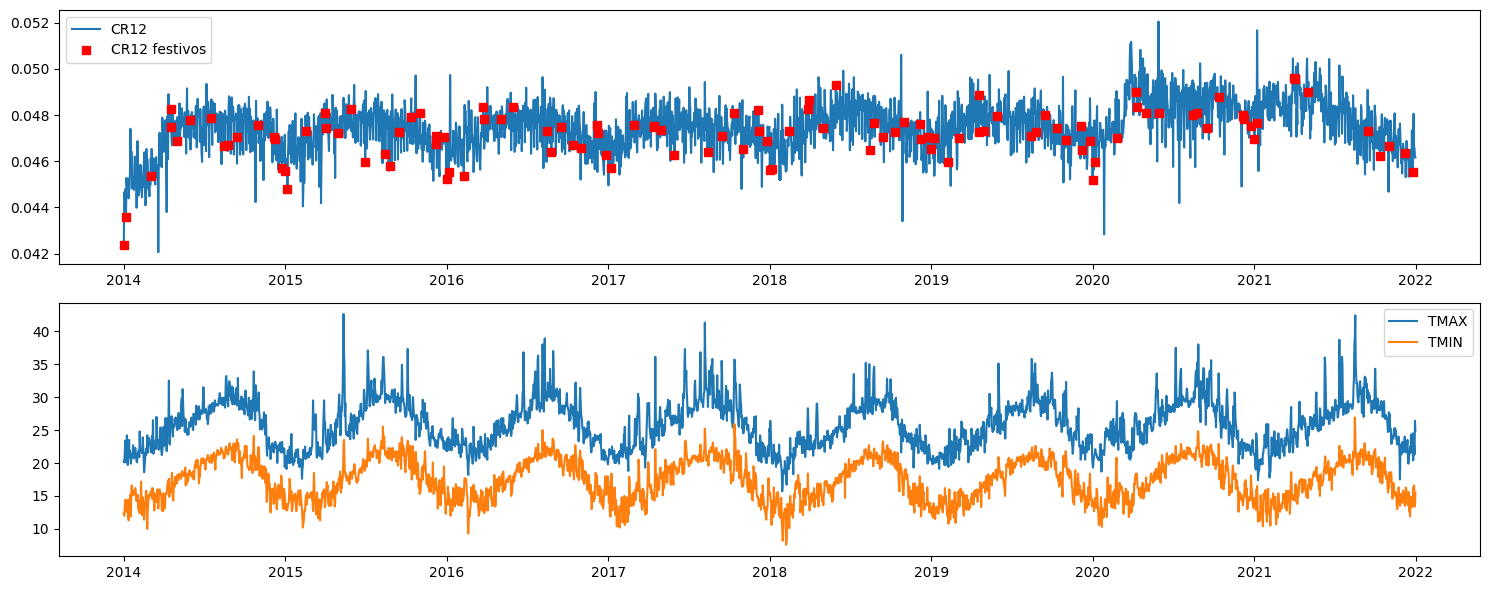

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [3]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

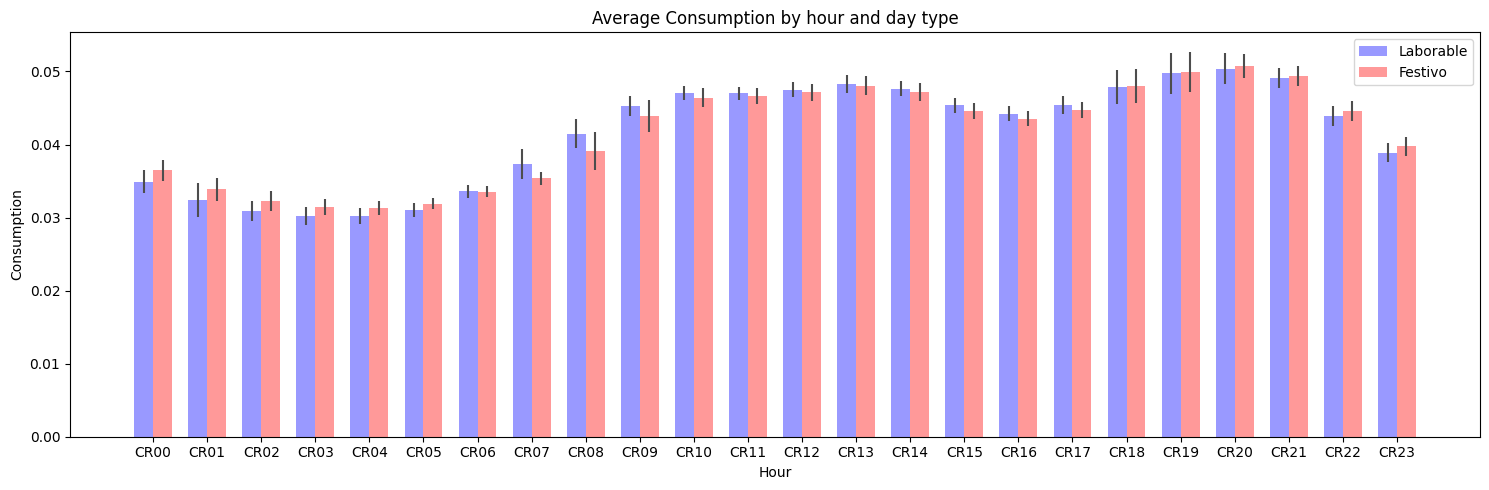

In [4]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_f = df_aju[(df_aju.FESTIVO == 1)]
del df_f["FECHA"]
del df_f["MES"]
del df_f["TMIN"]
del df_f["TMAX"]
del df_f["DIASEM"]
del df_f["FESTIVO"]

df_l = df_aju[df_aju.FESTIVO == 0]
del df_l["FECHA"]
del df_l["MES"]
del df_l["TMIN"]
del df_l["TMAX"]
del df_l["DIASEM"]
del df_l["FESTIVO"]

# #-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig, ax = plt.subplots(figsize = (15,5))

index = np.arange(len(df_f.columns))  
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(df_l.columns, df_l.mean(), bar_width,
                alpha=opacity, color='b',
                yerr=df_l.std(),
                error_kw=error_config,
                label='Laborable')

rects2 = ax.bar(index + bar_width, df_f.mean(), bar_width,
                alpha=opacity, color='r',
                yerr=df_f.std(),
                error_kw=error_config,
                label='Festivo')

ax.set_xlabel('Hour')
ax.set_ylabel('Consumption')
ax.set_title('Average Consumption by hour and day type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_l.columns)
ax.legend()

fig.tight_layout()
plt.show()

#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

In [6]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [7]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [8]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [9]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Define input and output matrices
INPUTS = df_aju.columns[~df_aju.columns.isin(['FESTIVO', 'FECHA', ''])]
OUTPUT = 'FESTIVO'
X = df_aju[INPUTS]
y = df_aju[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
df_aju_tr = X_train.copy()
df_aju_tr['FESTIVO'] = y_train # We will call Y as output variable for simplicity
df_aju_ts = X_test.copy()
df_aju_ts['FESTIVO'] = y_test # We will call Y as output variable for simplicity>

In [10]:
param = {'GB__min_impurity_decrease': [0.001 * np.var(y_train)]}
         # 'GB__min_samples_split' : np.arange(2,7)} # Minimum entropy to decrease in each split

number_estimators = 300
learning_rate = 0.08
max_depth = 3
min_impurity_decrease =  0.001 * np.var(y_train)

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 11)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('GB', GradientBoostingClassifier(n_estimators=number_estimators,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth,
                                            max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                            loss = 'log_loss',   # binomial and multinomial deviance
                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                            min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                            random_state=0))]) # For replication

In [11]:
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
INPUTS_BT = INPUTS
nFolds = 10

pipe.fit(X_train_SMOTE[INPUTS_BT], y_train_SMOTE) # Search in grid

Pipeline(steps=[('scaler', StandardScaler()),
                ('GB',
                 GradientBoostingClassifier(learning_rate=0.08,
                                            max_features=1.0, n_estimators=300,
                                            random_state=0))])

In [14]:
# model predictions in training (TR) and test (TS) sets
clf = pipe
y_train_pred = clf.predict(X_train_SMOTE[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train_SMOTE,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train_SMOTE,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train_SMOTE, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.982639
Balanced accuracy  1.0  0.845114

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    1    0
         1 2211    0
         0    0 2211

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  3 550

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.34
Sensitivity: 0.99
Specificity: 0.7
Precision: 0.84
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.95
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.76
Positive label: 1


In [15]:
# # model predictions in training (TR) and test (TS) sets
# clf = gbt_fit.best_estimator_['GB']

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Fit the scaler to the data
# scaler.fit(X_train[INPUTS_BT])

# # Transform the data using the scaler
# scaled_df = scaler.transform(X_train[INPUTS_BT])
# scaled_test_df = scaler.transform(X_test[INPUTS_BT])

# # Convert the transformed data back to a dataframe
# scaled_df = pd.DataFrame(scaled_df, columns=X_train[INPUTS_BT].columns)
# scaled_test_df = pd.DataFrame(scaled_test_df, columns=X_test[INPUTS_BT].columns)

# y_train_pred = clf.predict(scaled_df).tolist()
# y_test_pred = clf.predict(scaled_test_df).tolist()

# # main metrics
# acc_tr = metrics.accuracy_score(y_train,y_train_pred)
# acc_ts = metrics.accuracy_score(y_test,y_test_pred)

# acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
# acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

# dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
# print(dfacc)

# print('\nMETRICS TRAINING:')
# CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
# print('\nMETRICS TEST SET:')
# CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

In [16]:
# clf.estimators_[0][0].tree_.node_count

In [17]:
## Plot the variable importance of each feature
# plt.figure(figsize=(19, 4))
# bar_width = 0.35
# plt.bar(INPUTS_BT, gbt_fit.best_estimator_['GB'].feature_importances_, color='black', alpha=0.5)
# plt.xlabel('features')
# plt.ylabel('Importance')
# plt.show()

In [18]:
import pickle
filename = "./models/gradient_boosting.pickle"
pickle.dump(pipe, open(filename, "wb"))

#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [19]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [20]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

##### Desbalanceo
Cuando hablamos de datos desbalanceados, nos referimos a conjuntos de datos donde **una o varias clases tienen una cantidad significativamente menor de ejemplos que otras clases**. La representación en el dataset de días festivos es inferior al 4%, por lo que está **moderadamente desbalanceado (1-20%)** [1]. Esto causa que los modelos presenten una tendencia a clasificar todas las muestras como "no festivas", ya que de esta manera alcanzan una accuracy de aproximadamente 96%. Por lo tanto, es de extrema importancia **no utilizar la medida de accuracy** para evaluar los modelos. 

Para ello, destacan dos medidas: la **"balanced accuracy" y el "F1-score"**. La primera es una medida que tiene en cuenta el desbalanceo en las clases y es la media aritmética de las tasas de verdaderos positivos (TPR) y verdaderos negativos (TNR). La **Balanced Accuracy es adecuada cuando ambas clases tienen una importancia similar**, y cuando el objetivo es tener una tasa de clasificación correcta equilibrada entre ambas clases. Por otro lado, el F1-score combina tanto la precisión como el recall del modelo. Es adecuada cuando se desea equilibrar la importancia de la precisión y el recall. Esta medida es particularmente útil cuando el objetivo es **detectar correctamente los casos positivos** (la clase minoritaria en situaciones de desbalanceo), pero a costa de un mayor número de falsos positivos.

Para este trabajo, se ha elegido utilizar el **F1-score** ya que se ha considerado más útil identificar más días festivos, a costa de clasificar erróneamente un mayor número de "no festivos". Sin embargo, la balanced accuracy también podría ser una elección adecuada si para la aplicación fuese perjudicial obtener un número alto de falsos positivos. Por tanto, al tunear los hiperparámetros de los modelos, se han **elegido aquellos con un mayor F1-score**. Además, a la hora de evaluarlos, se compararán utilizando esta métrica. Por último, también se analizaran las puntuaciones de las medidad se Precision y Recall con el fin de entender en qué tipo de muestras se producen los fallos de los modelos.

Sin embargo, utilizar estas métricas puede no ser suficiente para obtener un buen resultado ya que al haber tan poca representación de la clase "Festivo", **es posible que no haya suficente información para que los modelos la aprendan**. Para compensarlo, se pueden utilizar técnicas de balanceo. En este contexto, el submuestreo y el sobremuestreo son técnicas utilizadas para abordar el desbalanceo en los datos.

El **submuestreo implica eliminar ejemplos de la clase mayoritaria** para equilibrar la distribución de clases. Sin embargo, esto puede llevar a la pérdida de información y disminuir la capacidad de generalización del modelo.

El **sobremuestreo, por otro lado, consiste en generar nuevos ejemplos de la clase minoritaria** para igualar su cantidad con la clase mayoritaria. Esta técnica puede aumentar el tamaño del conjunto de datos y permitir que el modelo aprenda más sobre la clase minoritaria, mejorando así la capacidad de generalización. Sin embargo, si se realiza de forma indiscriminada, puede llevar a la sobrecarga de información y al sobreajuste del modelo.

**SMOTE (Synthetic Minority Over-sampling Technique)** es una técnica de sobre-muestreo para conjuntos de datos desbalanceados. Esta técnica **genera nuevos datos sintéticos** de la clase minoritaria (la clase con menos ejemplos) mediante la **interpolación entre las instancias existentes**. Para ello, SMOTE selecciona aleatoriamente una instancia de la clase minoritaria y calcula los k vecinos más cercanos de esta instancia. A continuación, SMOTE elige aleatoriamente uno de estos vecinos y genera un nuevo punto sintético a lo largo del segmento que une la instancia seleccionada con su vecino seleccionado. Repitiendo este proceso para varias instancias de la clase minoritaria, SMOTE crea una nueva base de datos sintética que tiene un equilibrio más equitativo entre las clases. Esta técnica ha demostrado ser efectiva para mejorar el rendimiento de los algoritmos de aprendizaje automático en problemas de clasificación desbalanceados.

En este proyecto se ha utilizado la técnica de SMOTE en algunos algoritmos para mejorar su rendimiento. Es importante tener en cuenta que la técnica **se debe aplicar tan solo al conjunto de training**, nunca al de test o al de validación, ya que de hacerlo la evaluación se estaría realizando sobre un conjunto de datos sintético, que podría no ser representativo de la realidad.

##### Complejidad

Es importante conocer la complejidad de un modelo ya que esto puede afectar su **rendimiento y su capacidad para generalizar** correctamente. La complejidad puede medirse en términos de la complejidad temporal y espacial, así como la interpretabilidad del modelo.

- **Complejidad Espacial**: La complejidad espacial se refiere al espacio de memoria requerido para almacenar el modelo. Un modelo complejo puede requerir una gran cantidad de memoria, lo que puede ser un problema en sistemas con limitaciones de recursos. Por lo tanto, es importante evaluar la complejidad espacial junto con la complejidad temporal para garantizar que el modelo sea viable en términos de recursos. En este tipo de complejidad es clave el número de parámetros, el cual afecta de forma proporcional.

- **Complejidad Temporal**: La complejidad temporal se refiere al tiempo necesario para entrenar el modelo y hacer predicciones. Si un modelo es demasiado complejo, puede llevar mucho tiempo entrenar y predecir, lo que puede ser impráctico en situaciones donde se requiere una respuesta en tiempo real. Por lo tanto, es importante equilibrar la complejidad con la eficiencia temporal del modelo.

- **Interpretabilidad**: la interpretabilidad del modelo se refiere a la capacidad de entender cómo el modelo toma decisiones. Un modelo complejo puede ser difícil de interpretar, lo que puede ser un problema en situaciones donde es importante comprender la lógica detrás de las decisiones del modelo, como puede ser por ejemplo el ámbito médico. Por lo tanto, es importante evaluar la complejidad del modelo en términos de su interpretabilidad para garantizar que se pueda explicar adecuadamente cómo se tomaron las decisiones. En resumen, conocer la complejidad de un modelo es fundamental para garantizar su eficacia, eficiencia y comprensibilidad. A la hora de medir la interpretabilidad, es primordial tener en cuenta la estructura del modelo, las variables utilizadas y la importancia de las mismas.

Para calcular la complejidad espacial y la temporal, se han utilizado fórmulas aplicadas a cada algoritmo [2] [3], las cuales tienen en cuenta los siguientes parámetros:

- N = número de muestras
- d =dimensiones
- c = número de clases
- n = número de nodos
- k = número de árboles
- p = número de componentes principales

| Modelo                | Compl. Tiempo             | Compl. Espacio          | Interpretabilidad |
|-----------------------|---------------------------|-------------------------|-------------------|
| **Simple Tree**       | O(log(N))                 |  O(n)                   |  Alta             |
| **Bagged Tree**       | O(k log(N) )              |  O(n k)                 |  Baja             |
| **Random Forest**     | O(k log(N) )              |  O(n k)                 |  Baja             |
| **Gradient Boosting** | O(k log(N) )              |  O(n k)                 |  Baja             |
| **Stacking**          | O((k1 + k2 + k3) 3log(N)) |  O (k1n1 + k2n2 + k3n3) |  Muy Baja         |
| **PCA + Simple Tree** | O((N+1) d p)              |  O(N + d p)             |  Media            |

Para un mismo número de muestras y de nodos por árbol, el modelo de Simple Tree es el modelo más sencillo tanto en tiempo como en espacio. Además, es el más interpretable ya que se puede observar con claridad el flujo de toma de decisiones que lleva a acabo para la clasificación. Será, por tanto, el más sencillo de explicar a una persona no experta en machine learning.

##### Capacidad de Generalización
La capcidad de generalización de un modelo se define como su habilidad para trabajar con muestras nunca vistas, es decir, muestras que no se han utilizado para su entrenamiento. Para comparar la capacidad de generalización de los distintos modelos, se analizan las diferencias entre el las métricas en training y test de los distintos modelos, especialmente el la Balanced Accuracy y el F1-score. Se utiliza esta medida en lugar de la accuracy ya que, como se mencionó antes, debido al desbalanceo entre clases del dataset, esta medida no refleja correctamente la eficacia del modelo. Además, se usan la Precision y el Recall en test, como forma sencilla de comparar sus respectivas matrices de confusión.

Una puntuación alta en training pero relativamente baja en test significa que el modelo ha sobreaprendido las muestras de entrenamiento, y no es lo suficiciente general como para predecir correctamente el conjunto de test.

La tabla a continuación muestra las diferentes métricas obtenidas por los mejores modelos de cada tipo. 

| Modelo                | Acc TR | Acc TS | Bal Acc TR | Bal Acc TS | F1 TR | F1 TS | Precision TS | Recall TS | Underfitting | Overfitting*|
|-----------------------|--------|--------|------------|------------|-------|-------|--------------|-----------|--------------|-------------|
| **Simple Tree**       | 96.01% | 96.01% | 50%        | 50%        | 0     | 0     | 0%           | 0%        | High         | -           |
| **Bagged Tree**       | 100%   | 99%    | 94.57%     | 84.69%     | 0.94  | 0.80  | 94%          | 70%       | -            | Moderate    |
| **Random Forest**     | 99.73% | 98.26% | 96.73%     | 82.42%     | 0.97  | 0.75  | 88%          | 65%       | -            | High        |
| **Gradient Boosting** | 100%   | 98.26% | 100%       | 84.51%     | 1     | 0.76  | 84%          | 70%       | -            | High        |
| **Stacking**          | 100%   | 98%    | 99%        | 78%        | 0.99  | 0.7   | 93%          | 57%       | -            | High        |
| **PCA + Simple Tree** | 99.60% | 96.70% | 95.10%     | 77.04%     | 0.95  | 0.58  | 59%          | 57%       | -            | High        |

**The overfitting was meassured according to the TR and TS F1-score difference and the scale used was: {Low: < 0.1, Moderate: >0.1 and <0.2, High: >0.2}*

En términos de F1 en test, el mejor modelo es el Bagged tree, el cual alcanza el una puntuación de 0.8. Según el criterio elegido, es el mejor modelo.

Además, el Bagged Tree es el modelo que mejor capacidad de generalización presenta, al ser en el que existen menos diferencias entre las métricas de training y de test (exceptuando al Simple Tree, pero este modelo presenta mucho bias), con una diferencia de 9.88 pp en Balanced Accuracy y de 0.14 en F1-score. Este modelo se consiguió reducir el error en test mediante la reducción de complejidad del modelo, lo cual evitaba que se sobreajustase.

Para analizar las diferencias en las matrices de confusión, se han añadido en la tabla las métricas de Precision y Recall. Las conclusiones son las siguientes:
- En el Simple Tree, se ve claramente cómo el modelo, al predecir todo como "No festivo", no es capaz de encontrar ninguna muestra positiva (Precision y Recall = 0%)
- El Bagged Tree acierta al 94% las muestras que clasifica "Festivos", pero no encuentra los encuentra todos (encuentra un 65%). Esto porbablemente suceda por el desbalanceo de clases, porque para obtener una mayor precisión en test al modelo "le interesa" clasificar todo como "No festivo".
- El modelo de Random Forest acierta un 88% de las muestras que clasifica como "Festivas" (Precision = 88%), pero tan solo encuentra un 65% de los festivos (Recall = 65%).
- La situación con el Gradient Boosting es similar al Bagged Tree, si bien la puntuación es ligeramente más baja en Recall (65%).
- El modelo de staking obtiene una puntuación alta en Precision (93%), pero baja en Recall (57%).

##### Tasa de fallos según el día de la semana

Para calcular la tasa de fallos según el día de la semana, ejecutamos el siguiente código:

In [21]:
def calculate_metrics(estimator, X_train, X_test, y_train, y_test):
    clf = estimator
    y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
    y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

    # main metrics
    acc_tr = metrics.accuracy_score(y_train,y_train_pred)
    acc_ts = metrics.accuracy_score(y_test,y_test_pred)

    acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
    acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

    dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
    print(dfacc)

    print('\nMETRICS TRAINING:')
    CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
    print('\nMETRICS TEST SET:')
    CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

**Lunes**

In [22]:
X_train_l = X_train[X_train.DIASEM == 1]
X_test_l = X_test[X_test.DIASEM == 1]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
loaded_bt = pickle.load(open("./models/bagged_tree_v2.pickle", "rb"))
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR        TS
Accuracy           1.0  0.989130
Balanced accuracy  1.0  0.994253

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   0
         0  0 299

Accuracy: 1.0
No Information Rate: 0.9
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.95
Detection Rate: 0.95
Detection prevalence: 0.95
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  5  0
         0  1 86

Accuracy: 0.99
No Information Rate: 0.89
P-Value [Acc > NIR]: 0.04
Kappa: 0.9
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.99
Specificity: 1.0
Precision: 0.83
Recall: 1.0
Prevalence: 0.95
Detection Rate: 0.93
Detection prevalence: 0.93
Balanced accuracy: 0.99
F1 Score: 0.91
Positive label: 1


**Martes**

In [23]:
X_train_l = X_train[X_train.DIASEM == 2]
X_test_l = X_test[X_test.DIASEM == 2]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR   TS
Accuracy           1.0  1.0
Balanced accuracy  1.0  1.0

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 18   0
         0  0 312

Accuracy: 1.0
No Information Rate: 0.9
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.95
Detection Rate: 0.95
Detection prevalence: 0.95
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  4  0
         0  0 74

Accuracy: 1.0
No Information Rate: 0.9
P-Value [Acc > NIR]: 0.02
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.95
Detection Rate: 0.95
Detection prevalence: 0.95
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1


**Miércoles**

In [24]:
X_train_l = X_train[X_train.DIASEM == 3]
X_test_l = X_test[X_test.DIASEM == 3]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR   TS
Accuracy           1.0  1.0
Balanced accuracy  1.0  1.0

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 11   0
         0  0 329

Accuracy: 1.0
No Information Rate: 0.94
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.97
Detection Rate: 0.97
Detection prevalence: 0.97
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  3  0
         0  0 69

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.05
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1


**Jueves**

In [25]:
X_train_l = X_train[X_train.DIASEM == 4]
X_test_l = X_test[X_test.DIASEM == 4]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR   TS
Accuracy           1.0  1.0
Balanced accuracy  1.0  1.0

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 20   0
         0  0 316

Accuracy: 1.0
No Information Rate: 0.89
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.94
Detection Rate: 0.94
Detection prevalence: 0.94
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  0  0
         0  0 78

Accuracy: 1.0
No Information Rate: 1.0
P-Value [Acc > NIR]: 1.0
Kappa: nan
Mcnemar's Test P-Value: 1.0
Precision: 0.5
Recall: 0.5
Balanced accuracy: 1.0
F1 Score: 0.5
Positive label: 1


**Viernes**

In [26]:
X_train_l = X_train[X_train.DIASEM == 5]
X_test_l = X_test[X_test.DIASEM == 5]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR        TS
Accuracy           1.0  0.988095
Balanced accuracy  1.0  0.900000

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 18   0
         0  0 314

Accuracy: 1.0
No Information Rate: 0.9
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.95
Detection Rate: 0.95
Detection prevalence: 0.95
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  4  1
         0  0 79

Accuracy: 0.99
No Information Rate: 0.9
P-Value [Acc > NIR]: 0.04
Kappa: 0.88
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 0.8
Precision: 1.0
Recall: 0.8
Prevalence: 0.94
Detection Rate: 0.94
Detection prevalence: 0.95
Balanced accuracy: 0.9
F1 Score: 0.89
Positive label: 1


**Sábado**

In [27]:
X_train_l = X_train[X_train.DIASEM == 6]
X_test_l = X_test[X_test.DIASEM == 6]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR        TS
Accuracy           1.0  0.945652
Balanced accuracy  1.0  0.500000

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1  8   0
         0  0 314

Accuracy: 1.0
No Information Rate: 0.95
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.98
Detection Rate: 0.98
Detection prevalence: 0.98
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  0  5
         0  0 87

Accuracy: 0.95
No Information Rate: 0.95
P-Value [Acc > NIR]: 0.62
Kappa: 0.0
Mcnemar's Test P-Value: 0.06
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.95
Detection Rate: 0.95
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1


**Domingo**

In [28]:
X_train_l = X_train[X_train.DIASEM == 7]
X_test_l = X_test[X_test.DIASEM == 7]
y_train_l = y_train[y_train.index.isin(X_train_l.index)]
y_test_l = y_test[y_test.index.isin(X_test_l.index)]
calculate_metrics(loaded_bt, X_train_l[INPUTS_BT], X_test_l[INPUTS_BT], y_train_l, y_test_l)

                    TR        TS
Accuracy           1.0  0.975000
Balanced accuracy  1.0  0.493671

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1  1   0
         0  0 327

Accuracy: 1.0
No Information Rate: 0.99
P-Value [Acc > NIR]: 0.37
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 1.0
Detection Rate: 1.0
Detection prevalence: 1.0
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1  0  1
         0  1 78

Accuracy: 0.98
No Information Rate: 0.98
P-Value [Acc > NIR]: 0.92
Kappa: -0.01
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.99
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.99
Detection Rate: 0.98
Detection prevalence: 0.99
Balanced accuracy: 0.49
F1 Score: 0.0
Positive label: 1


En la tabla a continuación se comparan las métricas obtenidas para cada día de la semana:
| Día                   | Acc TR | Acc TS | Bal Acc TR | Bal Acc TS | F1 TR | F1 TS | Precision TS | Recall TS |
|-----------------------|--------|--------|------------|------------|-------|-------|--------------|-----------|
| **Lunes**             | 89.25% | 98.91% | 91.41%     | 99.43%     | 0.91  | 0.91  | 83%          | 100%      |
| **Martes**            | 93.62% | 98.43% | 93.62%     | 84.60%     | 0.93  | 0.78  | 89%          | 70%       |
| **Miércoles**         | 93.62% | 98.43% | 96.73%     | 82.42%     | 0.97  | 0.75  | 88%          | 65%       |
| **Jueves**            | 97.28% | 98.44% | 97.28%     | 82.51%     | 0.97  | 0.77  | 94%          | 65%       |
| **Viernes**           | 89.81% | 98.80% | 90.06%     | 90.00%     | 0.90  | 0.89  | 100%         | 80%       |
| **Sábado**            | 91.34% | 94.56% | 64.77%     | 50.00%     | 0.46  | 0.00  | 0%           | 0%        |
| **Domingo**           | 100%   | 97.50% | 100%       | 49.36%     | 1.00  | 0.00  | 0%           | 0%        |

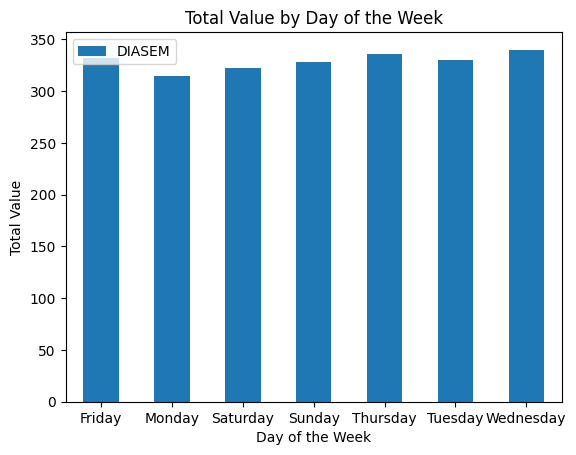

In [29]:

# create a dictionary to map numeric values to day names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# create a new column with day names
X_train['DAY_NAME'] = X_train['DIASEM'].map(day_names)

# group the DataFrame by day name and sum the values in the other columns
grouped = X_train[['DAY_NAME', 'DIASEM']].groupby('DAY_NAME').count()

# create a bar plot of the grouped data
ax = grouped.plot(kind='bar', width=0.5)

# set the plot title and axis labels
plt.title('Total Value by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Value')

# set the rotation of the x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# show the plot
plt.show()

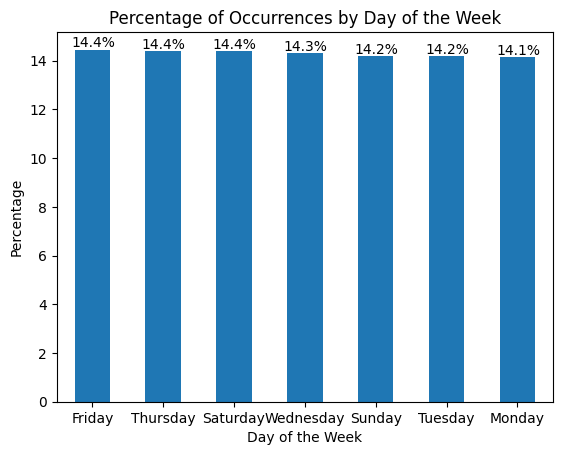

In [30]:
# create a dictionary to map numeric values to day names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# create a new column with day names
df_aju['DAY_NAME'] = df_aju['DIASEM'].map(day_names)

# count the occurrences of each day name
counts = df_aju['DAY_NAME'].value_counts()

# calculate the percentage of occurrences of each day name
percentages = (counts / counts.sum()) * 100

# create a bar plot of the percentages
ax = percentages.plot(kind='bar', width=0.5)

# set the plot title and axis labels
plt.title('Percentage of Occurrences by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage')

# set the rotation of the x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for i, v in enumerate(percentages):
    ax.text(i-0.3, v+0.1, "{:.1f}%".format(v), color='black')

# show the plot
plt.show()

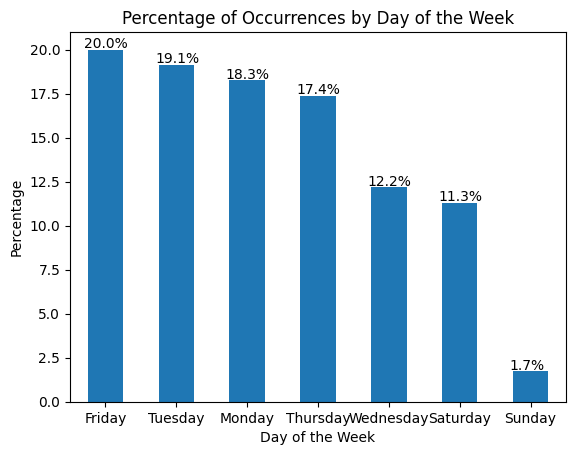

In [31]:
df_f = df_aju[(df_aju.FESTIVO == 1)]

# create a dictionary to map numeric values to day names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# create a new column with day names
df_f['DAY_NAME'] = df_f['DIASEM'].map(day_names)

# count the occurrences of each day name
counts = df_f['DAY_NAME'].value_counts()

# calculate the percentage of occurrences of each day name
percentages = (counts / counts.sum()) * 100

# create a bar plot of the percentages
ax = percentages.plot(kind='bar', width=0.5)

# set the plot title and axis labels
plt.title('Percentage of Occurrences by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage')

# set the rotation of the x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for i, v in enumerate(percentages):
    ax.text(i-0.3, v+0.1, "{:.1f}%".format(v), color='black')

# show the plot
plt.show()

**Modelo de producción**

El modelo a elegir para producción depende en gran medida de la aplicación. Lo más importante es que generalice correctamente para que sea capaz de adaptarse a nuevas muestras. Sin embargo, dependiendo de el uso que se vaya a hacer del modelo, puede ser más importante que clasifique correctamente una clase u otra. Entre los diferentes objetivos que pueden existir están acertar el mayor número de veces posible, encontrar todos los días festivos o que todos los días que se clasifiquen como festivos estén correctamente clasificados. Además, según el uso, se puede priorizar un modelo interpretable porque se necesite conocer la lógica detrás de la toma de decisiones.

Aunque no se especifica ninguna aplicación en específico para este proyecto, se puede asumir que el objetivo es entender cómo varía el uso de la electricidad según si el día es festivo o no. La lógica detrás de esta asumpción es que con tan solo mirar un calendario, se puede saber qué día es festivo con mayor precisión de la que va aportar un modelo. Sin embargo, A una compañía eléctrica le puede interesar conocer las diferencias en el consumo de energía en días festivos y no festivos por varias razones:

En primer lugar, el conocimiento de las diferencias en el consumo de energía durante días festivos y no festivos puede ayudar a la compañía a planificar la generación y distribución de energía de manera más efectiva. Por ejemplo, si se espera que el consumo de energía sea menor en días festivos, la compañía puede reducir la producción de energía y ajustar la distribución en consecuencia para evitar el desperdicio de recursos.

En segundo lugar, el conocimiento de las diferencias en el consumo de energía en días festivos y no festivos puede ayudar a la compañía a ajustar sus precios y tarifas para garantizar la rentabilidad y la eficiencia en la producción de energía. Si se espera que el consumo de energía sea menor en días festivos, la compañía puede reducir los precios para atraer a más consumidores y mantener la demanda de energía.

En tercer lugar, el conocimiento de las diferencias en el consumo de energía en días festivos y no festivos puede ayudar a la compañía a optimizar el uso de sus recursos, lo que puede ser beneficioso tanto desde una perspectiva económica como medioambiental. Si se espera que el consumo de energía sea menor en días festivos, la compañía puede programar el mantenimiento y la reparación de equipos y maquinarias para evitar interrupciones en la producción de energía en días de alta demanda.

En conclusión, conocer las diferencias en el consumo de energía en días festivos y no festivos puede proporcionar a una compañía eléctrica información valiosa para planificar, ajustar los precios y tarifas, optimizar el uso de los recursos y mejorar su eficiencia y rentabilidad en la producción y distribución de energía, por lo que la interpretabilidad del modelo será un factor clave a tener en cuenta a la hora de elegir cuál poner en producción.

En el caso de este proyecto, la elección resulta muy sencilla porque el modelo de Bagged Trees destaca en todas las métricas. En primer lugar, es el modelo con menor diferencia entre los errores en training y en test, tanto en Accuracy (diferencia de 1 pp) como en Balanced Accuracy (diferencia de 9.88 pp) y F1-score (diferencia de 0.14). Además, es el modelo con mejores puntuaciones en test (Accuracy 99%, Balanced Accuracy 84.68% y F1-score 0.8).

Por lo tanto, el modelo que se elegiría para llevar a producción sería el Bagged Tree.

**AÑADIR TEMAS DE COMPLEJIDAD**

---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [32]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):
          FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0    2022-01-01  0.038935  0.037313  0.035291  0.033673  0.032924  0.033235   
1    2022-01-02  0.035271  0.033313  0.031889  0.031411  0.031302  0.031975   
2    2022-01-03  0.033756  0.032003  0.030669  0.030051  0.030199  0.031280   
3    2022-01-04  0.034484  0.032505  0.031375  0.030540  0.030431  0.031324   
4    2022-01-05  0.034669  0.032213  0.030933  0.030382  0.030527  0.031611   
..          ...       ...       ...       ...       ...       ...       ...   
352  2022-12-27  0.033279  0.031139  0.029907  0.029433  0.029757  0.030972   
353  2022-12-28  0.033250  0.031186  0.029934  0.029447  0.029821  0.030942   
354  2022-12-29  0.033718  0.031695  0.030290  0.029717  0.030014  0.031075   
355  2022-12-30  0.033673  0.031494  0.030124  0.029639  0.029629  0.030732   
356  20

                   Validation
Accuracy             0.988796
Balanced accuracy    0.898538

METRICS VALIDATION SET FOR GRADIENT BOOSTING MODEL:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 12   3
         0  1 341

Accuracy: 0.99
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.85
Mcnemar's Test P-Value: 0.62
Sensitivity: 1.0
Specificity: 0.8
Precision: 0.92
Recall: 0.8
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.9
F1 Score: 0.86
Positive label: 1


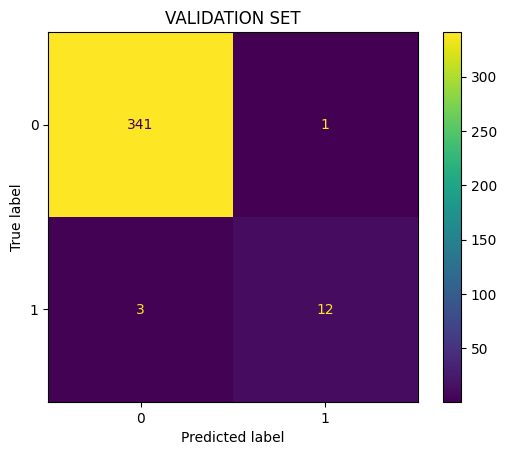

In [33]:
def calculate_metrics(clf_name, y_val_pred):
    # main metrics
    acc_ts = metrics.accuracy_score(y_val,y_val_pred)

    acc_bal_ts = metrics.balanced_accuracy_score(y_val,y_val_pred)

    dfacc =  pd.DataFrame([[acc_ts], [acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['Validation'])
    print(dfacc)

    print(f'\nMETRICS VALIDATION SET FOR {clf_name} MODEL:')
    CT.confusion_matrix(y_val, y_val_pred, labels=[1, 0])

def plot_matrix(clf):
    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val, ax = ax)
    plt.title ('VALIDATION SET')
    
    plt.show()

INPUTS = df_val.columns[~df_val.columns.isin(['FESTIVO', 'FECHA', ''])]
OUTPUT = 'FESTIVO'
X_val = df_val[INPUTS]
y_val = df_val[OUTPUT]

loaded_gb = pickle.load(open("./models/gradient_boosting.pickle", "rb"))
y_val_pred_gb = loaded_gb.predict(X_val).tolist()

calculate_metrics('GRADIENT BOOSTING', y_val_pred_gb)
plot_matrix(pipe)

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [34]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [35]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


# Referencias

[1] https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

[2] https://medium.com/analytics-vidhya/computational-complexity-of-ml-algorithms-1bdc88af1c7a

[3] https://en.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication

# MIMR

In [36]:
df_aju
df_fs = df_aju
df_fs.pop('FECHA')
df_fs.pop('DAY_NAME')
df_fs = pd.concat([df_fs['FESTIVO'], df_fs.drop('FESTIVO', axis=1)], axis=1)
df_fs

,FESTIVO,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR18,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,TMIN,TMAX
0,1,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.051983,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,12.3,20.2
1,0,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.052936,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,12.0,20.1
2,0,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.052802,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,13.2,21.0
3,0,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.051650,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,14.4,23.4
4,0,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.051721,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,0,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.049918,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,16.1,23.0
2875,0,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.049899,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,16.6,22.7
2876,0,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.049712,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,14.3,21.3
2877,0,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.050167,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,13.4,26.4


In [37]:
from pymrmr import mrmr

selected_features = mrmr(df_fs, k=5, method='MIQ')

ImportError: cannot import name 'mrmr' from 'pymrmr' (C:\Users\Maria\anaconda3\envs\ml\lib\site-packages\pymrmr.cp39-win_amd64.pyd)

In [38]:
!pip install mrmr_selection

In [46]:
# from mrmr import mrmr_classif
# y = df_fs.pop('FESTIVO')
# selected_features = mrmr_classif(X=df_fs, y=y, K=5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.00it/s]


In [62]:
selected_features = ['CR00', 'CR02', 'CR04', 'CR06', 'CR08',  'CR08',  'CR10',  'CR12',  'CR14',  'CR16',  'CR18',  'CR20',  'CR22','DIASEM', 'TMIN']

In [63]:
df_fs

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,CR18,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,TMIN,TMAX
0,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,0.039427,...,0.051983,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,12.3,20.2
1,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,0.045132,...,0.052936,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,12.0,20.1
2,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,0.046046,...,0.052802,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,13.2,21.0
3,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,0.044597,...,0.051650,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,14.4,23.4
4,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,0.043760,...,0.051721,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,0.046865,...,0.049918,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,16.1,23.0
2875,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,0.046844,...,0.049899,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,16.6,22.7
2876,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,0.047131,...,0.049712,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,14.3,21.3
2877,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,0.046639,...,0.050167,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,13.4,26.4


In [64]:
# selected_features.append('DIASEM')
INPUTS_BT = selected_features
nFolds = 10

pipe.fit(X_train[INPUTS_BT], y_train) # Search in grid

Pipeline(steps=[('scaler', StandardScaler()),
                ('GB',
                 GradientBoostingClassifier(learning_rate=0.08,
                                            max_features=1.0, n_estimators=300,
                                            random_state=0))])

In [65]:
INPUTS_BT

['CR00',
 'CR02',
 'CR04',
 'CR06',
 'CR08',
 'CR08',
 'CR10',
 'CR12',
 'CR14',
 'CR16',
 'CR18',
 'CR20',
 'CR22',
 'DIASEM',
 'TMIN']

In [66]:
# model predictions in training (TR) and test (TS) sets
clf = pipe
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.982639
Balanced accuracy  1.0  0.824279

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 15   8
         0  2 551

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.74
Mcnemar's Test P-Value: 0.11
Sensitivity: 1.0
Specificity: 0.65
Precision: 0.88
Recall: 0.65
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.82
F1 Score: 0.75
Positive label: 1


In [52]:
X_train

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,TMIN,TMAX,DAY_NAME
1377,0.033432,0.031196,0.029568,0.028963,0.029163,0.030012,0.033315,0.038977,0.042116,0.045980,...,0.051124,0.051147,0.047681,0.042417,0.038004,10,5,21.1,29.4,Friday
1234,0.035935,0.033053,0.031186,0.030397,0.030699,0.031034,0.032984,0.038133,0.042211,0.045515,...,0.048281,0.048968,0.049896,0.044584,0.038773,6,2,18.4,26.8,Tuesday
2404,0.036040,0.033847,0.032276,0.031304,0.031344,0.032149,0.034521,0.036691,0.040217,0.044088,...,0.045588,0.047793,0.048499,0.043255,0.038745,9,2,21.2,26.2,Tuesday
2107,0.033528,0.031604,0.030522,0.029745,0.029641,0.030518,0.034264,0.039753,0.044356,0.047296,...,0.050757,0.049277,0.045569,0.039726,0.035360,11,2,18.5,26.6,Tuesday
924,0.034672,0.031471,0.029986,0.029259,0.029057,0.029838,0.032149,0.035238,0.040561,0.044284,...,0.049479,0.048983,0.049335,0.044642,0.039751,7,2,22.9,36.3,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0.033219,0.031192,0.030123,0.029776,0.030144,0.031335,0.035529,0.040518,0.044376,0.047079,...,0.051041,0.050058,0.046436,0.040682,0.036355,11,4,17.8,24.8,Thursday
1046,0.036484,0.033705,0.032264,0.031138,0.031359,0.032421,0.033791,0.035531,0.040767,0.045412,...,0.052525,0.051435,0.048132,0.042900,0.038212,11,7,15.4,23.8,Sunday
299,0.036355,0.033484,0.031724,0.031081,0.031018,0.031940,0.033465,0.034848,0.039482,0.043070,...,0.053555,0.051679,0.048515,0.043348,0.038827,11,7,22.4,30.7,Sunday
882,0.033951,0.031392,0.029962,0.029659,0.029722,0.030657,0.033279,0.037457,0.042347,0.045542,...,0.048467,0.048423,0.049664,0.044833,0.039739,6,1,19.3,27.0,Monday


In [53]:
X_train[INPUTS_BT]

,CR08,CR16,CR11,CR02,CR07,DIASEM
1377,0.042116,0.045445,0.047330,0.029568,0.038977,5
1234,0.042211,0.044140,0.046840,0.031186,0.038133,2
2404,0.040217,0.044529,0.047622,0.032276,0.036691,2
2107,0.044356,0.044931,0.047581,0.030522,0.039753,2
924,0.040561,0.046182,0.047520,0.029986,0.035238,2
...,...,...,...,...,...,...
2825,0.044376,0.044093,0.046818,0.030123,0.040518,4
1046,0.040767,0.042845,0.046117,0.032264,0.035531,7
299,0.039482,0.043925,0.045952,0.031724,0.034848,7
882,0.042347,0.045291,0.047141,0.029962,0.037457,1


In [54]:
INPUTS_BT

['CR08', 'CR16', 'CR11', 'CR02', 'CR07', 'DIASEM']